**ML4SCI Hackathon entry submitted by Team**:
(In alphabetical order)

Jing Lu - lujingeve158@gmail.com or jl16x@my.fsu.edu

Lawrence Ng - lng1492@gmail.com or ln16@my.fsu.edu

Pak Ki Henry Tsang - henrytsang222@gmail.com or pt14b@my.fsu.edu

# Circumgalactic Medium Challenge - Dimensionality Reduction

<a href="https://colab.research.google.com/github/ML4SCI/ML4SCIHackathon/blob/main/CircumgalacticMediumChallenge/DimensionalityReduction_CGM.ipynb" 
target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem description 

Galaxies are embedded in large gas haloes termed the “circumgalactic medium (CGM)”. The history of a galaxy is encapsulated in the history of its gas cycling between the visible body of the galaxy and the CGM. The CGM is a source for a galaxy’s star-forming fuel, and plays a role in regulating the galactic gas supply. Understanding the CGM and its history thus offers insight into galaxy evolution. 

One way to study galaxy CGMs is through the absorption lines they cause in the spectra of bright background objects, such as quasars. As the light passes through a slab of gas constituting the CGM, the gas absorbs part of the light, resulting in an absorption line in the resulting spectrum, as the figure below illustrates. 

(Note that the light intensity is always **non-negative**).

![image](https://user-images.githubusercontent.com/71390120/131004001-9958b083-11c0-4a62-aedf-073a7b629ad1.png)

The characteristics of the absorption lines depend on the properties and type of the gas itself. Thus, it is plausible that there are some underlying/latent gas characteristics, such as density, temperature, elemental abundances and velocity that result in spectra with similar characteristics. These properties are unobservable, which motivates the search for an underlying latent space — a low-dimensional representation of spectra, which would capture these properties.

Your task will be to find a latent space from which the original spectra can be reconstructed with minimal information loss, as described in more detail below.

# Data

You will be given a dataset of simulated spectra, where a given row corresponds to a single spectrum, and each column corresponds to a wavelength. That is, entry $ x_{i,j} $ in the given data is light intensity for spectrum $ i $ at wavelength $ j $ (so the plot above is a plot of one row of the data).

We provide three datasets:
1. Training data: This should be used for model fitting.
2. Validation data: Hyperparameter tuning should be done using this dataset.
3. Test data: Use your FINAL model to calculate reconstructions for this data. DO NOT use this for model fitting. 

You can do anything with the train and validation datasets (for example, if using cross-validation you can pool them). Test data should be only used once, to generate reconstructions using your final model. 

Note that we will use a separate dataset (which you won't have access to) to assess the submitted models.


# Objective

Given a dataset of spectra, your task is to reduce its dimensionality. For example, starting with 2000 spectra with 100 000 features/wavelengths, your task is to represent these spectra with just a few features. For example, you can end up with a dataset of 2000 spectra, each with 6 features (instead of the original 100 000 features).

Below we will refer to the features of the reduced spectra as "latent variables". So in the example above, the reduced spectrum has 6 latent variables.

The dimensionality reduction necessarily involves some information loss. Your aim is to find dimensionality reduction with as small loss as possible. This loss is calculated as a mean squared error of reconstructed spectra. See below for more detail.









# Information loss and custimized tanh

Your task is to minimise information loss, which will be measured by reconstruction loss. We give you a function to calculate the information loss below. The function takes the latent space size and the original and reconstructed spectra as inputs. 

**How to obtain reconstructed spectra**
1. First use your model to encode the original spectrum (let's call it $ s $) with 100 000 features/wavelengths, using only $ d $ features. This results in a reduced spectrum. 

2. Then, use (only) the reduced spectrum to reconstruct the original spectrum (so from a reduced spectrum with $ d $ features now obtain one with 100 000 features). This results in a reconstructed spectrum. Let's call it $ \hat{s} $.


Once you have your model for dimensionality reduction, calculating the reconstructed spectra is easy. For example, for PCA in sklearn, you can simply use ".inverse_transform". For autoencoders, reconstructions are calculated using your decoder.

*When calculating reconstructions, it is useful to keep in mind that the light intensity is always* **non-negative**, *so in general, non-negative reconstructions will lead to lower loss.*

**How is the reconstruction loss calculated**

We want the original spectrum and the reconstructed spectrum to be as similar as possible, while encouraging small latent space size (small $ d $). Hence we calculate reconstruction loss for a single spectrum with $ p $ wavelengths as a mean squared error of reconstructed vs. original spectrum, with added penalty for large $ d $.

Note that the penalty increases with increasing $ d $. Also, extra penalty is added if you use more than 6 latent features. So it pays off to reduce the dimensionality as much as possible, and definitely to use maximum of 6 latent features!

$$ \text{Reconstruction loss}(s) = \frac{1}{p} \sum_{i = 1}^{p}(s_{i} - \hat{s}_{i})^{2} + \psi_{1} d + \psi_{2} \mathbb{I}\{d \geq 7\} $$


For a dataset of $ N $ spectra, we simply average the losses, i.e.


$$ \text{Penalised reconstr. loss}(s^{1}, ... , s^{N}) = \frac{1}{pN }  \sum_{j = 1}^{N} \sum_{i = 1}^{p}(s^{j}_{i} - \hat{s}^{j}_{i})^{2} + \psi_{1} d + \psi_{2} \mathbb{I}\{d \geq 7\}. $$


**Function to calculate the reconstruction loss**

In [ ]:
def reconstr_loss(original_spectra, reconstructed_spectra, latent_dim):
  '''Function to calculate reconstruction loss.

  Inputs:
  - original_spectra (np.array): original spectra.
  - reconstructed_spectra (np.array): reconstruction of the original spectra from the latent representation.
  - latent_dim (integer): size of the latent space.

  Returns:
  - reconstruction loss with added penalty for the latent space size
  '''

  penalty = 0.00003
  penalty2 = 5*0.00003


  mse_loss = mean_squared_error(original_spectra, reconstructed_spectra, squared=True)
  loss_penalized = mse_loss + latent_dim*penalty + penalty2*(latent_dim > 6)

  return(loss_penalized)

**Custmized activation function to ensure the output is within range**

In [ ]:
# Light intensity is non-negative, hence we enforce this restriction on the reconstructed spectra, too, by . 
# This helps to improve model performance.
def custom_tanh(x, target_min=0, target_max=None):
    '''
    For given max and min values, return tanh activation with values in this range

    Inputs:
    - x: values to be transformed (np.array)
    - target_min: minimum value of tanh function (float)
    - target_max: max value of tanh function (float)

    Returns:
    - x transformed by tanh activation (np.array)
    '''

    x_02range = tf.keras.activations.tanh(x) + 1  # x mapped into range(0,2)
    scale = (target_max - target_min) / 2.  # calculate target range of transformed x

    return (x_02range * scale + target_min)

# Specify custom decoder layer
# max_val = x_train.max().max()
# create custom tanh activation by specifying max value allowed for reconstructions
custom_tanh_activation = lambda x: custom_tanh(x, target_max=max_val)

# Our solution

### Load functions (after this, could directly jump to last subsection check the trained model


In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import h5py
!pip install gdown==4.1.1
import gdown


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in",\
               "xtick.major.size": 20, "ytick.major.size": 15})


# And these functions given in the example 
# Thanks for the detailed example, it's really clear and helpfull!!

def reconstr_loss(original_spectra, reconstructed_spectra, latent_dim):
  '''Function to calculate reconstruction loss.

  Inputs:
  - original_spectra (np.array): original spectra.
  - reconstructed_spectra (np.array): reconstruction of the original spectra from the latent representation.
  - latent_dim (integer): size of the latent space.

  Returns:
  - reconstruction loss with added penalty for the latent space size
  '''

  penalty = 0.00003
  penalty2 = 5*0.00003


  mse_loss = mean_squared_error(original_spectra, reconstructed_spectra, squared=True)
  loss_penalized = mse_loss + latent_dim*penalty + penalty2*(latent_dim > 6)

  return(loss_penalized)


# Light intensity is non-negative, hence we enforce this restriction on the reconstructed spectra, too, by . 
# This helps to improve model performance.
def custom_tanh(x, target_min=0, target_max=None):
    '''
    For given max and min values, return tanh activation with values in this range

    Inputs:
    - x: values to be transformed (np.array)
    - target_min: minimum value of tanh function (float)
    - target_max: max value of tanh function (float)

    Returns:
    - x transformed by tanh activation (np.array)
    '''

    x_02range = tf.keras.activations.tanh(x) + 1  # x mapped into range(0,2)
    scale = (target_max - target_min) / 2.  # calculate target range of transformed x

    return (x_02range * scale + target_min)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.1.1-py3-none-any.whl size=14211 sha256=dcc6ef12d567f6256dae05884082fd1337b73b138d157766bfe07e459fa4f72a
  Stored in directory: /root/.cache/pip/wheels/0c/45/5c/0c6bf549923e217b4a0fd24a90ce36e0d183ca50b7a1a7306d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


### Import data

In [ ]:
# url_train = 'https://drive.google.com/u/0/uc?export=download&confirm=F_-k&id=1sdx-m9PLLKjPQ8J2g7H2zw2FUSMV6jYz'
# url_val = 'https://drive.google.com/u/0/uc?export=download&confirm=QL45&id=1qymhB00l4wy_Ql4A3DRxguxytFzda7_0'
# url_test = 'https://drive.google.com/u/0/uc?export=download&confirm=nAB1&id=1lhJl_6lWCxNpOSxJd9_d_qssgUKEli7M'

# Using this links may be faster (but can fail if many users are connected)
url_train = 'https://drive.google.com/uc?id=1sdx-m9PLLKjPQ8J2g7H2zw2FUSMV6jYz'
url_val = 'https://drive.google.com/uc?id=1qymhB00l4wy_Ql4A3DRxguxytFzda7_0'
url_test = 'https://drive.google.com/uc?id=1lhJl_6lWCxNpOSxJd9_d_qssgUKEli7M'

train_set = gdown.download(url_train, 'train_set.hdf5', quiet=False)
val_set = gdown.download(url_val, 'val_set.hdf5', quiet=False)
test_set = gdown.download(url_test, 'test_set.hdf5', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1sdx-m9PLLKjPQ8J2g7H2zw2FUSMV6jYz
To: /content/train_set.hdf5
100%|██████████| 2.08G/2.08G [00:18<00:00, 112MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1qymhB00l4wy_Ql4A3DRxguxytFzda7_0
To: /content/val_set.hdf5
100%|██████████| 320M/320M [00:06<00:00, 51.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lhJl_6lWCxNpOSxJd9_d_qssgUKEli7M
To: /content/test_set.hdf5
100%|██████████| 160M/160M [00:01<00:00, 94.8MB/s]


## Process data

In [ ]:
## read the train, validate, test data set
data_train = h5py.File(train_set, 'r')
x_train = np.array( data_train['spectra'] )

data_val = h5py.File(val_set, 'r')
x_val = np.array( data_val['spectra'] )

data_test = h5py.File(test_set, 'r')
x_test = np.array( data_test['spectra'] )
print("Train size:", x_train.shape)
print("Val size:", x_val.shape)
print("Test size:", x_test.shape)

## Process the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))

train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

Train size: (6500, 39974)
Val size: (1000, 39974)
Test size: (500, 39974)


## Define and train the model

In [ ]:
### The following solution is based upon the given autoencoder example, but with:
## added one more layer and custmoized tanh at the final decoder layer

## Define encoder and decoder functions and objects
def get_encoder(encoded_dim, input_shape = x_train.shape[1]):
    encoder = Sequential([
        # Dense(512, input_shape = (input_shape,),activation = 'relu'),
        Dense(264, input_shape = (input_shape,),activation = 'relu'),
        Dense(128, activation = 'relu' ),
        Dense(encoded_dim),
    ])
    print(encoder.summary())
    return(encoder)

def get_decoder(encoded_dim, output_shape = x_train.shape[1]):
    decoder = Sequential([
        Dense(128, input_shape = (encoded_dim,), activation = 'relu'),
        Dense(264, activation = 'relu'),
        # Dense(512, activation = 'relu'),
        Dense(output_shape,activation=lambda x: custom_tanh(x, target_max=x_train.max().max())), # mapping_to_target_range
    ])
    print(decoder.summary())
    return(decoder)

## trainning the model
encoded_dim = 5
epochs = 100
optimizer_learning_rate = 1e-4 ## what should be the best value?

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)
encoder = get_encoder(encoded_dim, x_train.shape[1])
decoder = get_decoder(encoded_dim, x_train.shape[1])
# Initialise and compile VAE
ae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
optimizer = tf.keras.optimizers.Adam()
optimizer.learning_rate  = optimizer_learning_rate
ae.compile(optimizer=optimizer, loss = 'mean_squared_error')
ae_history = ae.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                    callbacks = [earlystopping])

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 264)               10553400  
                                                                 
 dense_205 (Dense)           (None, 128)               33920     
                                                                 
 dense_206 (Dense)           (None, 5)                 645       
                                                                 
Total params: 10,587,965
Trainable params: 10,587,965
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_207 (Dense)           (None, 128)               768       
                                                                 
 dense_208 (D

## Visualize the loss evolution

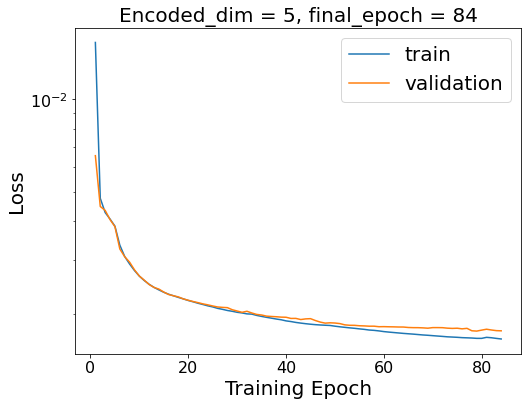

In [ ]:
train_loss,val_loss = np.array(ae_history.history['loss']),np.array(ae_history.history['val_loss'])
fig0,ax = plt.subplots(1,1,figsize=(8,6))
epochs_array =  np.arange(1,len(train_loss)+1,1)
ax.plot(epochs_array,train_loss,label='train')
ax.plot(epochs_array,val_loss,label='validation')
ax.set_xlabel('Training Epoch',fontsize=20)
ax.set_ylabel('Loss',fontsize=20)
ax.tick_params(labelsize=16)
ax.legend(fontsize=20)
ax.set_title('Encoded_dim = %d, final_epoch = %d'%(encoded_dim,epochs_array[-1]),fontsize=20)
ax.set_yscale('log')

## Functions and test loss needed for submission

In this case dimensionality reduction is performed by an encoder function, while calculating recnstructions is done by the decoder function.

In [ ]:
## dimension reduction and reconstruction functions
reduce_dimensionality = encoder
calculate_reconstructions = decoder

## loss of the model on the test set
test_set_latent_encoding = reduce_dimensionality(x_test)
test_set_reconstructions = calculate_reconstructions(test_set_latent_encoding)
## mean_squared_error(x_test, test_set_reconstructions, squared=True)
test_loss = reconstr_loss(x_test, test_set_reconstructions, latent_dim = test_set_latent_encoding.shape[1])
print('------------------------------------------------')
print('The reconstruction loss on the test set is:\n',test_loss)
print('------------------------------------------------')

------------------------------------------------
The reconstruction loss on the test set is:
 0.0018315898115098845
------------------------------------------------


##Find the optimized parameters



### Encoded dimensions?

Looking for optimized dim (lowest total loss change)
!! Very rough comparision, especially for 4 layers, 10 epoch is not near converagence at all


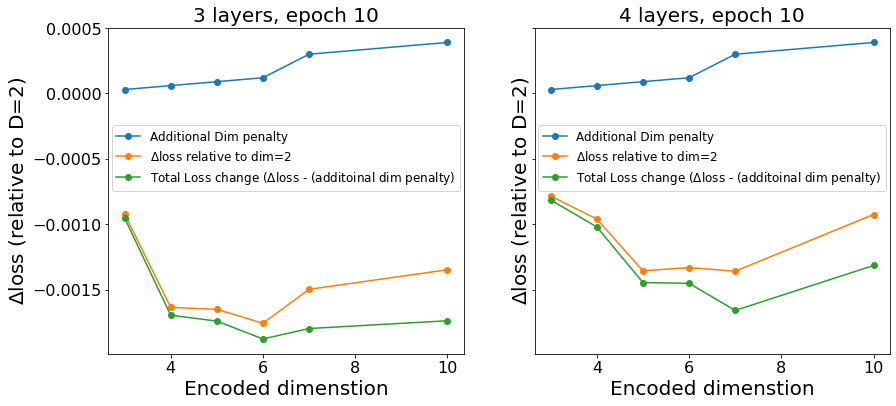

In [ ]:
print('Looking for optimized dim (lowest total loss change)')
print('!! Very rough comparision, especially for 4 layers, 10 epoch is not near converagence at all')
ig0,axes = plt.subplots(1,2,figsize=(14,6),sharex=True,sharey=True)

### previous trails with 3 layer at epoch=10:
latent_dims = np.array([2,3,4,5,6,7,10])
losses_3layer = np.array([0.0040541366987637125,0.003131476322134011,0.002417371078234493,
                   0.0024027664195611855,0.002295887306002924,0.0025557160740815764,
                   0.002705247008960065])
losses_4layer = np.array([0.004004104793431411,0.003218914727179865,0.0030429985060846654,
                          0.002647458953838646,0.0026717592359407514,0.002644122471987714,
                          0.003077937163503932])

penalty = 0.00003
penalty2 = 5*0.00003
dim_penalty = latent_dims*penalty + penalty2*np.array([int(latent_dim>6) for latent_dim in latent_dims])

for i,layers_num,losses in zip([0,1],[3,4],[losses_3layer,losses_4layer]):
    ax = axes[i]
    ax.plot(latent_dims[1:],dim_penalty[1:]-dim_penalty[0],label='Additional Dim penalty',marker='o')
    ax.plot(latent_dims[1:],(losses[1:]-losses[0]),label='$\Delta$loss relative to dim=2',marker='o')
    ax.plot(latent_dims[1:],(losses[1:]-losses[0])-(dim_penalty[1:]-dim_penalty[0]),label='Total Loss change ($\Delta$loss - (additoinal dim penalty)',marker='o')
    ax.set_xlabel('Encoded dimenstion',fontsize=20)
    ax.set_ylabel('$\Delta$loss (relative to D=2)',fontsize=20)
    ax.set_title('%d layers, epoch 10'%(layers_num),fontsize=20)
    ax.tick_params(labelsize=16)
    ax.legend(fontsize=12,loc='center',bbox_to_anchor=(0.5,0.6))

### Alright, let's stick with 5 or 6? Let's run more epochs to see, also it seems the early stoppinglearning rate also affect the test loss.

### learning rate?

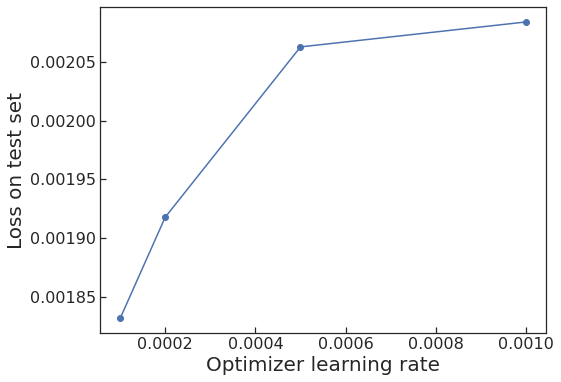

In [ ]:
# 3 layers, encoded_dim = 5, earlystopping epoch = 37, loss = 0.0020838352008212086 (learningrate=1e-3)
# 3 layers, encoded_dim = 5, earlystopping epoch = 34, loss = 0.002062618042984864 (learningrate=0.5e-3)  
# 3 layers, encoded_dim = 5, earlystopping epoch = 36, loss = 0.001917727729444021 (learningrate=0.2e-3)
# 3 layers, encoded_dim = 5, earlystopping epoch = 87, loss = 0.0018315898115098845 (learningrate=0.1e-3). - Took this one as final, Run time around 40min

learning_Rates = [1e-3,0.5e-3,0.2e-3,0.1e-3]
testlosses = [0.0020838352008212086,0.002062618042984864,0.001917727729444021,0.0018315898115098845]

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(learning_Rates,testlosses,marker='o')
ax.set_xlabel('Optimizer learning rate',fontsize=20)
ax.set_ylabel('Loss on test set',fontsize=20)
ax.tick_params(labelsize=16)


# 3 layers, encoded_dim = 6, earlystopping epoch = 25, loss = 0.002127458240214862 (learningrate=0.5e-3)
### How about add another layer in front? Hmm It's much more time consuming, abort. 
# 4 layers, encoded_dim = 6, earlystopping epoch = 16, loss = 0.00212737166465833 (leanring rate=0.5e-3)

## Visualize spectra

Encoded_dim = 5, final_epoch = 84
hmm the base line around 1.0 is not well constructed but I guess that is not the important part?


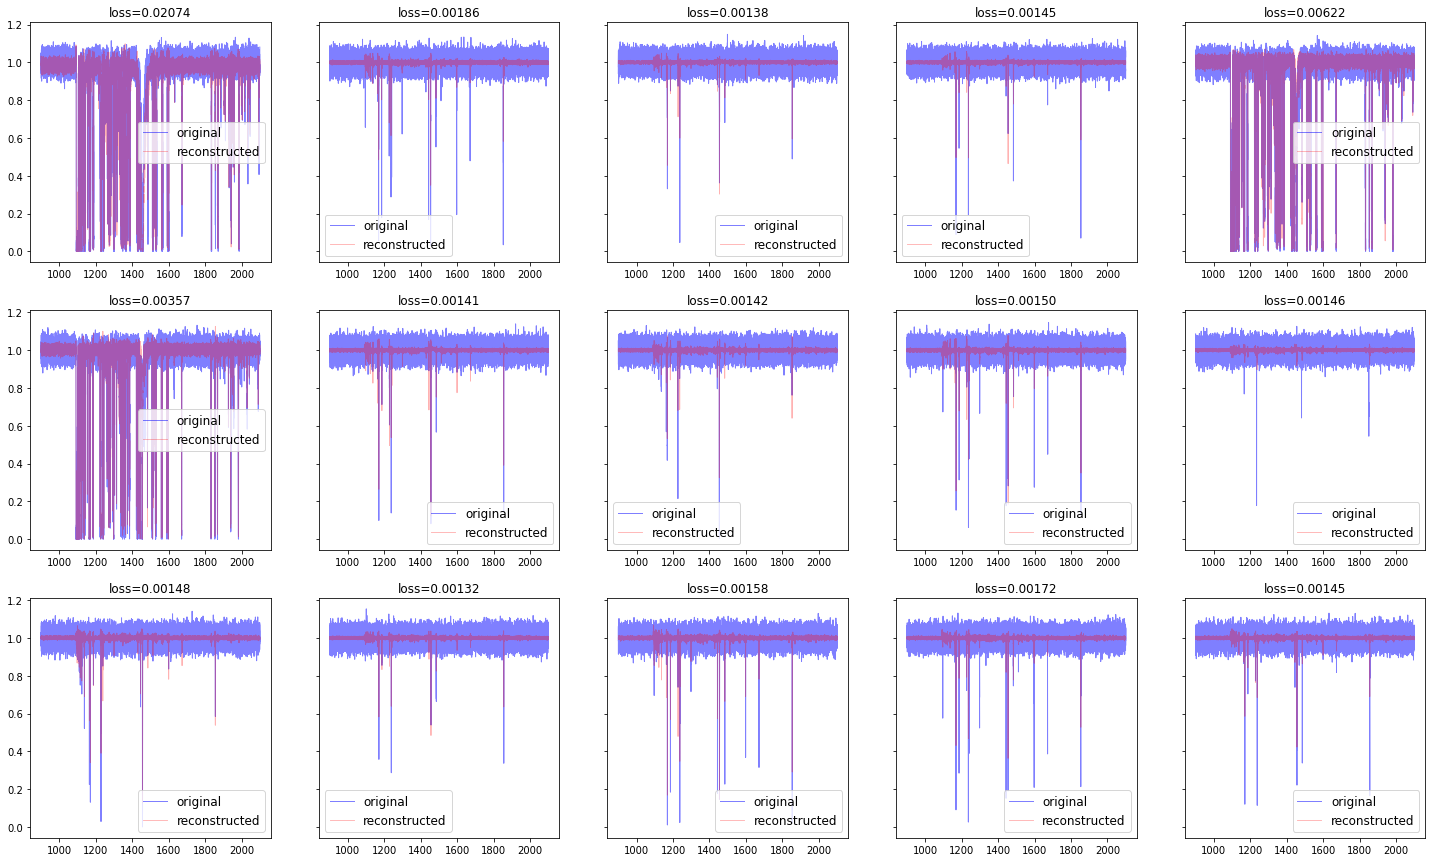

In [ ]:
def resontruction_visualization(orginal,resconstructed,x=np.array(data_test['wavelengths'])):
    N = orginal.shape[0]
    fig_row_num = np.floor_divide(N,5)+int(np.remainder(N,5)>0)
    fig,axes = plt.subplots(fig_row_num,5,figsize=(25,fig_row_num*5),sharey=True)
    for i in range(N):
        ax = axes.flatten()[i]
        ax.plot(x,orginal[i],color='b',lw=1,zorder=2,alpha=0.5, label='original')
        ax.plot(x,resconstructed[i],color='r',lw=0.9,zorder=2,alpha=0.3, label='reconstructed')
        ax.legend(fontsize=12)
        loss = reconstr_loss(orginal[i], resconstructed[i], encoded_dim)
        ax.set_title('loss=%.5f'%loss,fontsize=12)

orginal = x_test[np.random.choice(np.arange(0,x_test.shape[0]), size=15, replace=False, p=None)]
latent_encoding = reduce_dimensionality(orginal)
resconstructed = calculate_reconstructions(latent_encoding)

print('Encoded_dim = %d, final_epoch = %d'%(encoded_dim,epochs_array[-1]))
resontruction_visualization(orginal,resconstructed)
print('hmm the base line around 1.0 is not well constructed....')

##Save the model

In [ ]:
# encoder.save('our_encoder')
# decoder.save('our_decoder')

# from google.colab import files

# !zip -r /content/our_encoder.zip /content/our_encoder
# !zip -r /content/our_decoder.zip /content/our_decoder

# files.download("/content/our_encoder.zip")
# files.download("/content/our_decoder.zip")

INFO:tensorflow:Assets written to: our_encoder/assets
INFO:tensorflow:Assets written to: our_decoder/assets
  adding: content/our_encoder/ (stored 0%)
  adding: content/our_encoder/assets/ (stored 0%)
  adding: content/our_encoder/variables/ (stored 0%)
  adding: content/our_encoder/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/our_encoder/variables/variables.index (deflated 44%)
  adding: content/our_encoder/saved_model.pb (deflated 88%)
  adding: content/our_encoder/keras_metadata.pb (deflated 89%)
  adding: content/our_decoder/ (stored 0%)
  adding: content/our_decoder/assets/ (stored 0%)
  adding: content/our_decoder/variables/ (stored 0%)
  adding: content/our_decoder/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/our_decoder/variables/variables.index (deflated 44%)
  adding: content/our_decoder/saved_model.pb (deflated 87%)
  adding: content/our_decoder/keras_metadata.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Or Directly Load saved model after importing all functions

In [ ]:
### please make sure gdown is ar a higher version such as !pip install gdown==4.1.1, 
### the default version in colab didn't work for me when using gdown.download_folder

###""""But sometime this doesn't download the right content. try terminate the colab session and refresh."""###

url_encoder = 'https://drive.google.com/drive/folders/18YqRwJJNplIHumg6SKaJr8s_U-1YaAkP?usp=sharing'
url_decoder = 'https://drive.google.com/drive/folders/18FvKYYoCyfA6gSJeUUfQXIJ5pb7i9Av0?usp=sharing'
url_test = 'https://drive.google.com/u/0/uc?export=download&confirm=nAB1&id=1lhJl_6lWCxNpOSxJd9_d_qssgUKEli7M'

gdown.download_folder(url_encoder, quiet=False)
gdown.download_folder(url_decoder, quiet=False)
test_set = gdown.download(url_test, 'test_set.hdf5', quiet=False)

Retrieving folder list


Retrieving folder 18oWDdobI-N7rSKGfFDsEw9cxAmrnhyhQ assets
Retrieving folder 18mkU11xa9j_chS7eqNR1WRc54GFzA9Tr variables
Processing file 18qZJOLV59v4SfPCAmekqgdN1xcrobmth variables.data-00000-of-00001
Processing file 18tFQOYD5qPgdMWqnv3JXSDU_TX-Krtc5 variables.index
Processing file 18p7n0vX8opqbs-QHXyrDVXTUBCL0wPQJ keras_metadata.pb
Processing file 18knC0qCWCnIyl7UOZRuYjicRmvnyGi4j saved_model.pb
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=18qZJOLV59v4SfPCAmekqgdN1xcrobmth
To: /content/our_encoder/variables/variables.data-00000-of-00001
100%|██████████| 42.4M/42.4M [00:00<00:00, 195MB/s]
Downloading...
From: https://drive.google.com/uc?id=18tFQOYD5qPgdMWqnv3JXSDU_TX-Krtc5
To: /content/our_encoder/variables/variables.index
100%|██████████| 529/529 [00:00<00:00, 1.02MB/s]
Downloading...
From: https://drive.google.com/uc?id=18p7n0vX8opqbs-QHXyrDVXTUBCL0wPQJ
To: /content/our_encoder/keras_metadata.pb
100%|██████████| 7.52k/7.52k [00:00<00:00, 2.99MB/s]
Downloading...
From: https://drive.google.com/uc?id=18knC0qCWCnIyl7UOZRuYjicRmvnyGi4j
To: /content/our_encoder/saved_model.pb
100%|██████████| 61.0k/61.0k [00:00<00:00, 16.6MB/s]
Download completed
Retrieving folder list


Retrieving folder 18GeTPBakKh-qrn8Z4lfelneQ3m7Kr1yr assets
Retrieving folder 18V9mMqNiB__ZfnYNQpAUz_7vTc3qRM0L variables
Processing file 18VyYEjsW2XSDIW35hQHQ4Oe93JGjr3-5 variables.data-00000-of-00001
Processing file 18Xaw-T1_llHJShT5xmwIaPf0jsAh1Ca_ variables.index
Processing file 18SyVmj54erKxyLXpTzvNyoNFiezDztLe keras_metadata.pb
Processing file 18GDOHb56wbHkfNs_DgZynEfEQeog7EvA saved_model.pb
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=18VyYEjsW2XSDIW35hQHQ4Oe93JGjr3-5
To: /content/our_decoder/variables/variables.data-00000-of-00001
100%|██████████| 42.5M/42.5M [00:00<00:00, 175MB/s]
Downloading...
From: https://drive.google.com/uc?id=18Xaw-T1_llHJShT5xmwIaPf0jsAh1Ca_
To: /content/our_decoder/variables/variables.index
100%|██████████| 527/527 [00:00<00:00, 1.11MB/s]
Downloading...
From: https://drive.google.com/uc?id=18SyVmj54erKxyLXpTzvNyoNFiezDztLe
To: /content/our_decoder/keras_metadata.pb
100%|██████████| 7.49k/7.49k [00:00<00:00, 4.75MB/s]
Downloading...
From: https://drive.google.com/uc?id=18GDOHb56wbHkfNs_DgZynEfEQeog7EvA
To: /content/our_decoder/saved_model.pb
100%|██████████| 64.8k/64.8k [00:00<00:00, 32.1MB/s]
Download completed
Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=nAB1&id=1lhJl_6lWCxNpOSxJd9_d_qssgUKEli7M
To: /content/test_set.hdf5
100%|██████████| 160M/1

In [ ]:
data_test = h5py.File(test_set, 'r')
x_test = np.array( data_test['spectra'] )

our_encoder = tf.keras.models.load_model("our_encoder")
our_decoder = tf.keras.models.load_model("our_decoder")

test_set_latent_encoding = our_encoder(x_test)
test_set_reconstructions = our_decoder(test_set_latent_encoding)
test_loss = reconstr_loss(x_test, test_set_reconstructions, latent_dim = test_set_latent_encoding.shape[1])
print('------------------------------------------------')
print('------------------------------------------------')
print('The reconstruction loss on the test set is:\n',test_loss)
print('------------------------------------------------')
print('------------------------------------------------')

------------------------------------------------
------------------------------------------------
The reconstruction loss on the test set is:
 0.0018315898115098845
------------------------------------------------
------------------------------------------------


# Submission

Submission format (on ML4SCI2021@gmail.com):

Please email us:
 
1.   The link to your Google Colab Jupyter Notebook (or your Jupyter Notebook). The notebook should contain
  *   The final model.
  *   The two functions described above (one for dimensionality reduction and one for calculating reconstructions). The final model weights/parameters should be saved in a file and the two functions should use weights loaded from this file. (This is to make sure that we evaluate the model using the same weights as you)
  *   The loss calculation for the test set.
2. A link to a file storing the model architecture/weights (you can also send us the file, if it's of reasonable size). This can be in any format (as long as it loads correctly in your notebook).
3. The loss you obtained on your test set.

Feel free to choose the ML framework of your choice for this problem.
